<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/NN%20KAN%20timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Big zero shot to KAN Kolmogorov Arnold Networks**

Thanks a lot! https://github.com/OkDevBlog

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize
from numpy.polynomial.chebyshev import Chebyshev

# Chebyshev appriximation example

In [ ]:
degrees = 10
target_function = lambda x: np.sin(2 * np.pi * x)
x_vals = np.linspace(-1, 1, 500)

chebyshev_polynomials = [Chebyshev.basis(d) for d in range(degrees + 1)]
y_target = target_function(x_vals)

weights = np.ones(degrees + 1)
def weighted_sum(weights, x):
    return sum(w * cheb(x) for w, cheb in zip(weights, chebyshev_polynomials))

def objective(weights):
    y_approx = weighted_sum(weights, x_vals)
    return np.sum((y_target - y_approx) ** 2)

result = minimize(objective, weights)
optimal_weights = result.x

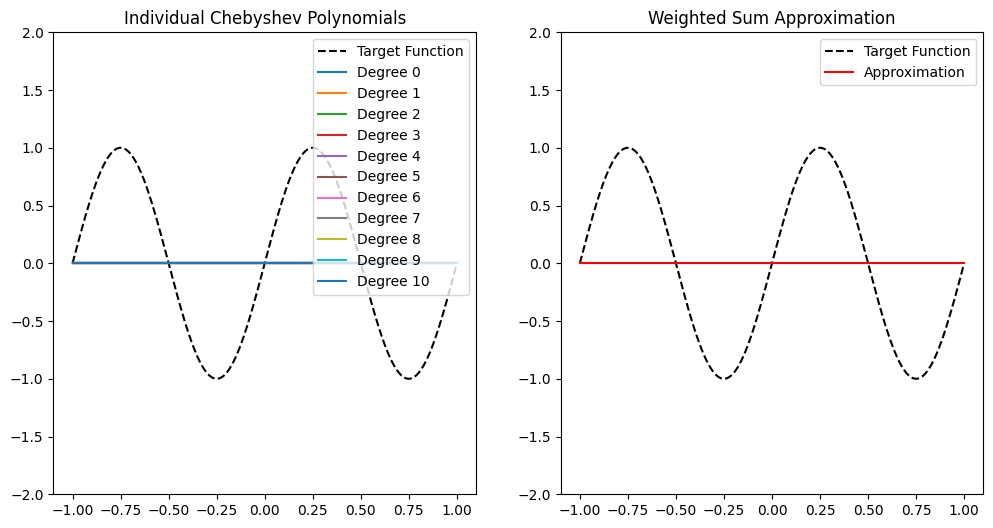

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title("Individual Chebyshev Polynomials")
ax2.set_title("Weighted Sum Approximation")

ax1.plot(x_vals, y_target, 'k--', label='Target Function')
ax2.plot(x_vals, y_target, 'k--', label='Target Function')

lines_cheb = [ax1.plot(x_vals, np.zeros_like(x_vals), label=f"Degree {i}")[0] for i in range(degrees + 1)]
line_approx, = ax2.plot(x_vals, np.zeros_like(x_vals), 'r-', label='Approximation')

ax1.set_ylim(-2, 2)
ax2.set_ylim(-2, 2)
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")

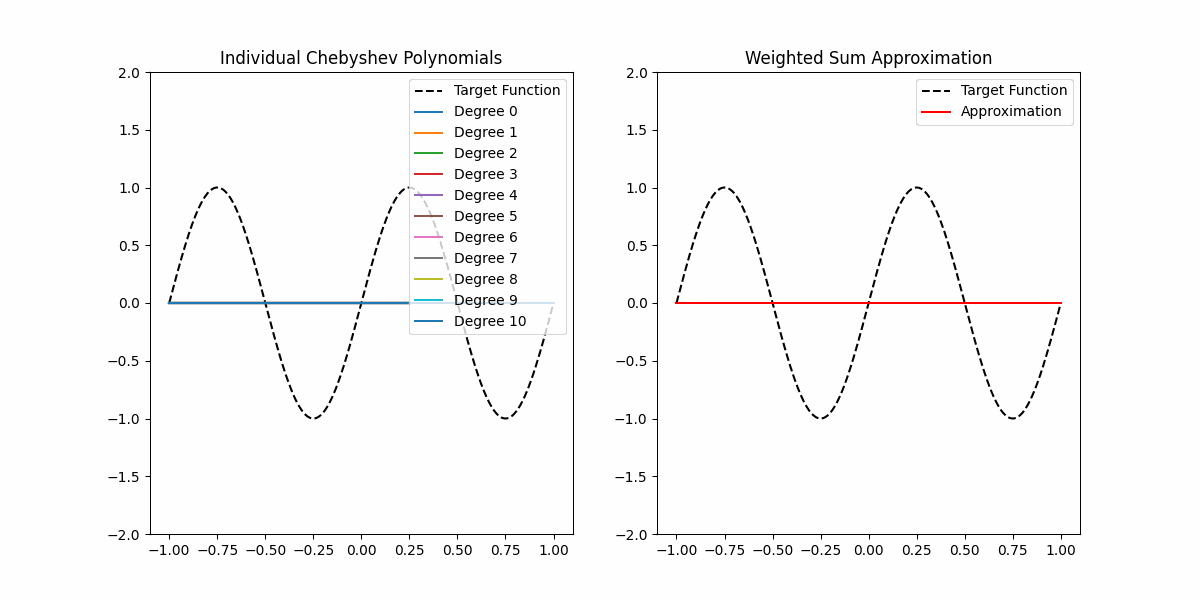

In [ ]:
from IPython.display import Image

Image(filename="chebyshev_approximation.gif")

In [ ]:
def update(degree):
    for i, line in enumerate(lines_cheb[:degree + 1]):
        line.set_ydata(optimal_weights[i] * chebyshev_polynomials[i](x_vals))

    y_approx = sum(optimal_weights[i] * chebyshev_polynomials[i](x_vals) for i in range(degree + 1))
    line_approx.set_ydata(y_approx)

    return lines_cheb + [line_approx]

ani = FuncAnimation(fig, update, frames=degrees + 1, interval=500, blit=True)

ani.save("chebyshev_approximation.gif", writer='imagemagick', fps=1)

# Vanilla KAN - dataframe prediction

In [ ]:
!pip install --quiet Deep-KAN

In [ ]:
!pip install -q KAN

In [ ]:
from deepkan import SplineLinearLayer

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class KANTimeSeries(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_knots=5, spline_order=3,
                 noise_scale=0.1, base_scale=1.0, spline_scale=1.0,
                 activation=nn.SiLU, grid_epsilon=0.02, grid_range=[-1, 1]):
        super(KANTimeSeries, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        self.layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(SplineLinearLayer(prev_size, hidden_size, num_knots, spline_order,
                                                 noise_scale, base_scale, spline_scale,
                                                 activation, grid_epsilon, grid_range))
            prev_size = hidden_size

        self.output_layer = SplineLinearLayer(prev_size, output_size, num_knots, spline_order,
                                              noise_scale, base_scale, spline_scale,
                                              activation, grid_epsilon, grid_range)

    def forward(self, x, update_knots=False):
        for layer in self.layers:
            if update_knots:
                layer._update_knots(x)
            x = layer(x)

        if update_knots:
            self.output_layer._update_knots(x)
        x = self.output_layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        loss = 0
        for layer in self.layers:
            loss += layer._regularization_loss(regularize_activation, regularize_entropy)
        loss += self.output_layer._regularization_loss(regularize_activation, regularize_entropy)
        return loss

In [ ]:
import torch
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf


In [ ]:
# KAN Implementation

# Load the Air Passengers dataset
data_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(data_url)
passengers_data = df["Passengers"].values.astype(np.float32)

# You could use Passengers timeseries example - just comment row below
#passengers_data = y_train_tensor

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
passengers_data_normalized = scaler.fit_transform(passengers_data.reshape(-1, 1)).flatten()

# Create input-output sequences for the time series data
def create_sequences(series, window_size):
    sequences = []
    for i in range(len(series) - window_size):
        sequences.append((series[i:i+window_size], series[i+window_size]))
    return sequences

window_size = 1  # Define the window size for input sequences
sequences = create_sequences(passengers_data_normalized, window_size)

# Convert data to PyTorch tensors
inputs_torch = torch.tensor([seq[0] for seq in sequences], dtype=torch.float32)
targets_torch = torch.tensor([seq[1] for seq in sequences], dtype=torch.float32)

# Initialize the KANTimeSeries model
input_size = window_size
hidden_sizes = [32]
num_knots = 5
spline_order = 3
model_torch_KAN = KANTimeSeries(input_size, hidden_sizes, 1, num_knots, spline_order)  # 1 for output_size

# Define the optimizer and loss function for KAN
optimizer_torch_KAN = torch.optim.Adam(model_torch_KAN.parameters(), lr=0.01)
criterion_torch_KAN = torch.nn.MSELoss()

In [ ]:
# Training loop for KAN
epochs = 20
losses_torch = []  # To store the losses during training
for epoch in range(epochs):
    epoch_loss = 0.0
    model_torch_KAN.train()
    for i in range(len(inputs_torch)):
        optimizer_torch_KAN.zero_grad()
        output = model_torch_KAN(inputs_torch[i:i+1])  # Take one sequence at a time
        target = targets_torch[i].view_as(output)
        loss = criterion_torch_KAN(output, target)
        loss.backward()
        optimizer_torch_KAN.step()
        epoch_loss += loss.item()

    # Print the epoch loss
    epoch_loss /= len(inputs_torch)
    print(f'KAN: Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}')
    losses_torch.append(epoch_loss)

    # Calculate predictions after each epoch for KAN
    with torch.no_grad():
        all_outputs_torch = model_torch_KAN(inputs_torch).squeeze().numpy()

KAN: Epoch [1/20], Loss: 0.024160
KAN: Epoch [2/20], Loss: 0.009781
KAN: Epoch [3/20], Loss: 0.008540
KAN: Epoch [4/20], Loss: 0.008793
KAN: Epoch [5/20], Loss: 0.007379
KAN: Epoch [6/20], Loss: 0.007027
KAN: Epoch [7/20], Loss: 0.006657
KAN: Epoch [8/20], Loss: 0.006404
KAN: Epoch [9/20], Loss: 0.006142
KAN: Epoch [10/20], Loss: 0.005902
KAN: Epoch [11/20], Loss: 0.005706
KAN: Epoch [12/20], Loss: 0.005562
KAN: Epoch [13/20], Loss: 0.005456
KAN: Epoch [14/20], Loss: 0.005374
KAN: Epoch [15/20], Loss: 0.005308
KAN: Epoch [16/20], Loss: 0.005251
KAN: Epoch [17/20], Loss: 0.005201
KAN: Epoch [18/20], Loss: 0.005155
KAN: Epoch [19/20], Loss: 0.005114
KAN: Epoch [20/20], Loss: 0.005076


In [ ]:
# MLP Implementation
# Define the MLP model using Keras
model_tf_MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(window_size,)),
    tf.keras.layers.Dense(1)
])

# Compile the model
model_tf_MLP.compile(optimizer='adam', loss='mean_squared_error')

# Training loop with storing loss values for MLP
losses_tf = []
for epoch in range(epochs):
    history = model_tf_MLP.fit(inputs_torch.numpy(), targets_torch.numpy(), epochs=1, verbose=0)
    loss = history.history['loss'][0]
    losses_tf.append(loss)
    print(f"TensorFlow/Keras: Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow/Keras: Epoch 1/20, Loss: 0.321061
TensorFlow/Keras: Epoch 2/20, Loss: 0.286306
TensorFlow/Keras: Epoch 3/20, Loss: 0.255259
TensorFlow/Keras: Epoch 4/20, Loss: 0.226670
TensorFlow/Keras: Epoch 5/20, Loss: 0.201758
TensorFlow/Keras: Epoch 6/20, Loss: 0.179718
TensorFlow/Keras: Epoch 7/20, Loss: 0.159413
TensorFlow/Keras: Epoch 8/20, Loss: 0.140450
TensorFlow/Keras: Epoch 9/20, Loss: 0.124999
TensorFlow/Keras: Epoch 10/20, Loss: 0.110111
TensorFlow/Keras: Epoch 11/20, Loss: 0.097913
TensorFlow/Keras: Epoch 12/20, Loss: 0.086620
TensorFlow/Keras: Epoch 13/20, Loss: 0.076530
TensorFlow/Keras: Epoch 14/20, Loss: 0.068283
TensorFlow/Keras: Epoch 15/20, Loss: 0.060380
TensorFlow/Keras: Epoch 16/20, Loss: 0.054378
TensorFlow/Keras: Epoch 17/20, Loss: 0.048954
TensorFlow/Keras: Epoch 18/20, Loss: 0.044134
TensorFlow/Keras: Epoch 19/20, Loss: 0.040465
TensorFlow/Keras: Epoch 20/20, Loss: 0.037306


In [ ]:
# Making predictions for MLP
predicted_data_normalized_tf = model_tf_MLP.predict(inputs_torch).flatten()

# Inverse transform the normalized data for KAN
passengers_data_denormalized_torch = scaler.inverse_transform(passengers_data_normalized.reshape(-1, 1)).flatten()
predicted_data_denormalized_torch = scaler.inverse_transform(all_outputs_torch.reshape(-1, 1)).flatten()

# Inverse transform the normalized data for MLP
passengers_data_denormalized_tf = scaler.inverse_transform(passengers_data_normalized.reshape(-1, 1)).flatten()
predicted_data_denormalized_tf = scaler.inverse_transform(predicted_data_normalized_tf.reshape(-1, 1)).flatten()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


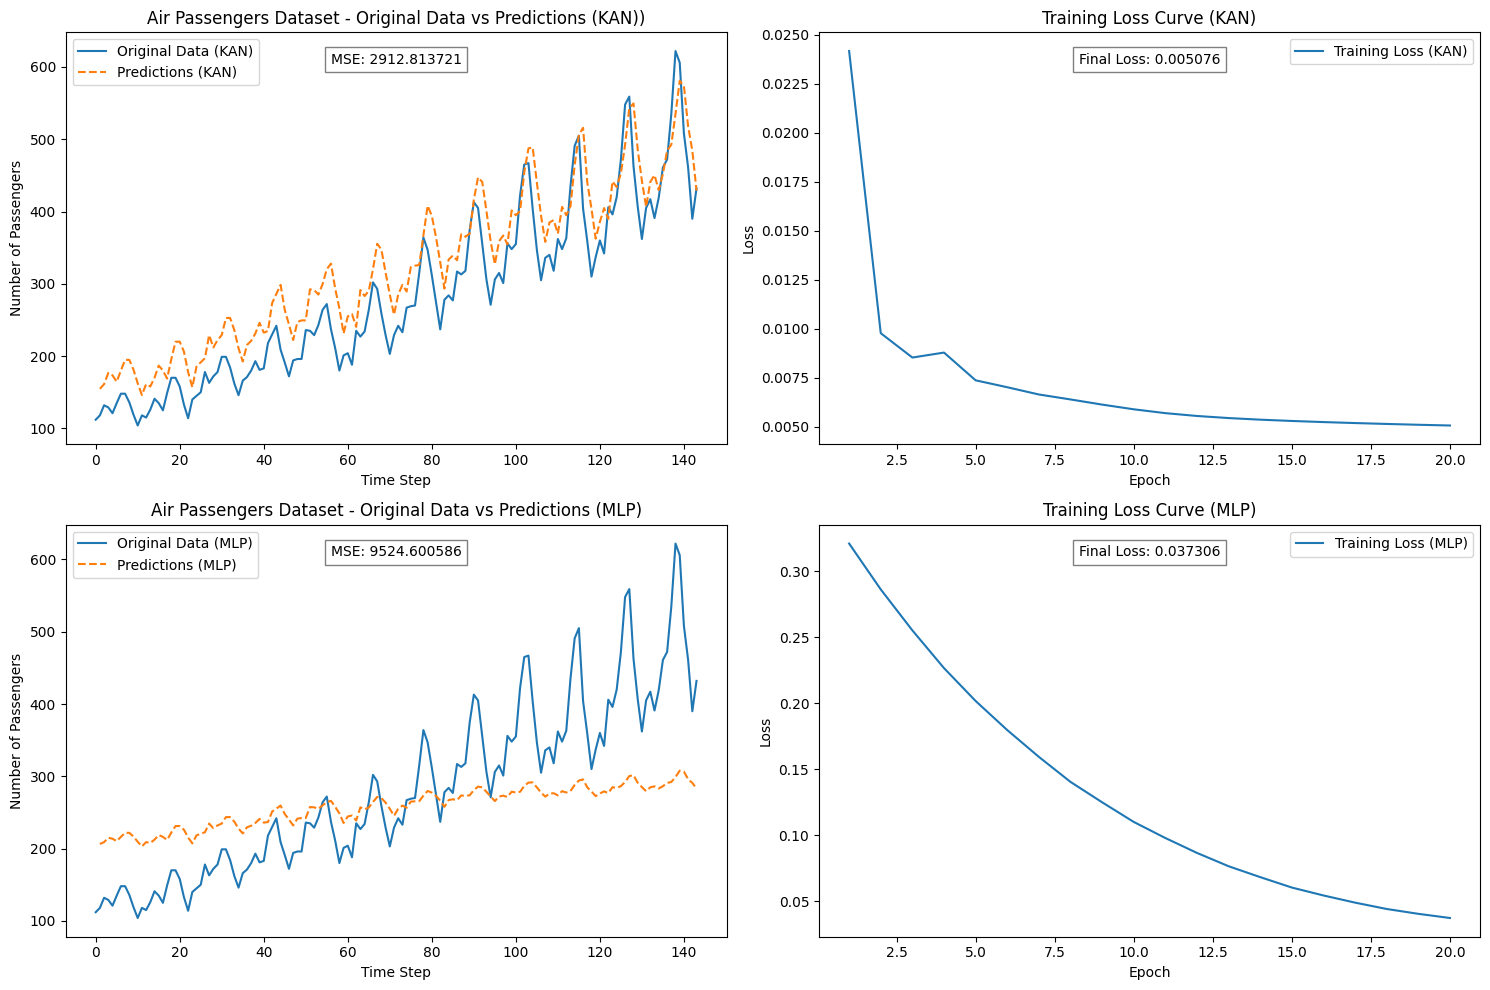

In [ ]:
# Calculate MSE for PyTorch
mse_torch = np.mean((passengers_data_denormalized_torch[window_size:] - predicted_data_denormalized_torch) ** 2)

# Calculate MSE for TensorFlow/Keras
mse_tf = np.mean((passengers_data_denormalized_tf[window_size:] - predicted_data_denormalized_tf) ** 2)

# Plotting side by side with loss curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot original data and predictions for PyTorch
axes[0, 0].plot(passengers_data_denormalized_torch, label='Original Data (KAN)')
axes[0, 0].plot(np.arange(window_size, len(passengers_data_denormalized_torch)), predicted_data_denormalized_torch, label='Predictions (KAN)', linestyle='--')
axes[0, 0].set_title('Air Passengers Dataset - Original Data vs Predictions (KAN))')
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('Number of Passengers')
axes[0, 0].legend()
axes[0, 0].text(0.5, 0.95, f'MSE: {mse_torch:.6f}', transform=axes[0, 0].transAxes, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Plot loss curve for KAN
axes[0, 1].plot(range(1, epochs+1), losses_torch, label='Training Loss (KAN)')
axes[0, 1].set_title('Training Loss Curve (KAN)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].text(0.5, 0.95, f'Final Loss: {losses_torch[-1]:.6f}', transform=axes[0, 1].transAxes, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Plot original data and predictions for MLP
axes[1, 0].plot(passengers_data_denormalized_tf, label='Original Data (MLP)')
axes[1, 0].plot(np.arange(window_size, len(passengers_data_denormalized_tf)), predicted_data_denormalized_tf, label='Predictions (MLP)', linestyle='--')
axes[1, 0].set_title('Air Passengers Dataset - Original Data vs Predictions (MLP)')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Number of Passengers')
axes[1, 0].legend()
axes[1, 0].text(0.5, 0.95, f'MSE: {mse_tf:.6f}', transform=axes[1, 0].transAxes, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Plot loss curve for MLP
axes[1, 1].plot(range(1, epochs+1), losses_tf, label='Training Loss (MLP)')
axes[1, 1].set_title('Training Loss Curve (MLP)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].text(0.5, 0.95, f'Final Loss: {losses_tf[-1]:.6f}', transform=axes[1, 1].transAxes, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# KAN with Chebyshev kernel

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class ChebyshevKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyshevKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def chebyshev_polynomials(self, x):
        T = [torch.ones_like(x), 2*x]
        for n in range(2, self.degree + 1):
            T.append(2 * x * T[n - 1] - T[n - 2])
        return torch.stack(T, dim=-1)

    def forward(self, x):
        x = x.view(-1, self.inputdim)
        x = torch.tanh(x)
        T = self.chebyshev_polynomials(x)
        y = torch.einsum("bij,ioj->bo", T, self.cheby_coeffs)
        y = y.view(-1, self.outdim)
        return y

class ChebyshevKAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, degree):
        super(ChebyshevKAN, self).__init__()
        self.chebyshevkan1 = ChebyshevKANLayer(input_dim, hidden_dim, degree)
        self.chebyshevkan2 = ChebyshevKANLayer(hidden_dim, output_dim, degree)

    def forward(self, x):
        x = self.chebyshevkan1(x)
        x = self.chebyshevkan2(x)
        return x

In [ ]:
# Define the target function
def complex_target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    mask2 = (0.5 <= x) & (x < 1.5)
    mask3 = x >= 1.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])
    y += np.sin(x**2) * np.exp(-x/3) + np.log1p(x) * np.cos(10 * np.pi * x)
    return y

# Generate training data
np.random.seed(0)
#x_train = np.random.uniform(0, 2, 2000)
x_train = np.linspace(0,2,2000)
y_train = complex_target_function(x_train)

data_ts = pd.read_csv('buffervar.csv', header=None)
#x_train = data_ts.index
y_train = data_ts[1]

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

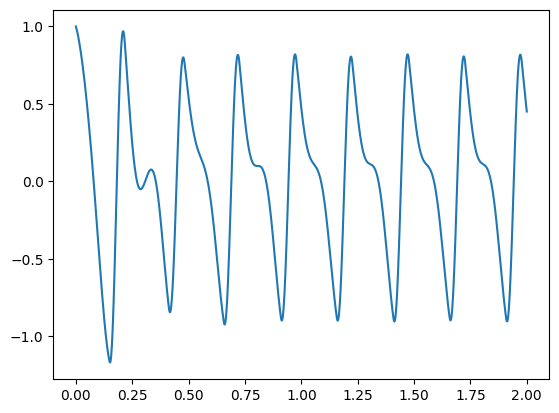

In [ ]:
plt.plot(x_train,y_train)

In [ ]:
# Define the parameters
lr = 0.01
hidden_dim = 40
degree = 13
num_epochs = 200

# Initialize the model
model = ChebyshevKAN(input_dim=1, hidden_dim=hidden_dim, output_dim=1, degree=degree)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')



Epoch 1/200, Loss: 0.7652
Epoch 11/200, Loss: 0.2453
Epoch 21/200, Loss: 0.1022
Epoch 31/200, Loss: 0.0328
Epoch 41/200, Loss: 0.0285
Epoch 51/200, Loss: 0.0261
Epoch 61/200, Loss: 0.0112
Epoch 71/200, Loss: 0.0052
Epoch 81/200, Loss: 0.0049
Epoch 91/200, Loss: 0.0040
Epoch 101/200, Loss: 0.0033
Epoch 111/200, Loss: 0.0030
Epoch 121/200, Loss: 0.0027
Epoch 131/200, Loss: 0.0025
Epoch 141/200, Loss: 0.0023
Epoch 151/200, Loss: 0.0059
Epoch 161/200, Loss: 0.0323
Epoch 171/200, Loss: 0.0020
Epoch 181/200, Loss: 0.0041
Epoch 191/200, Loss: 0.0026


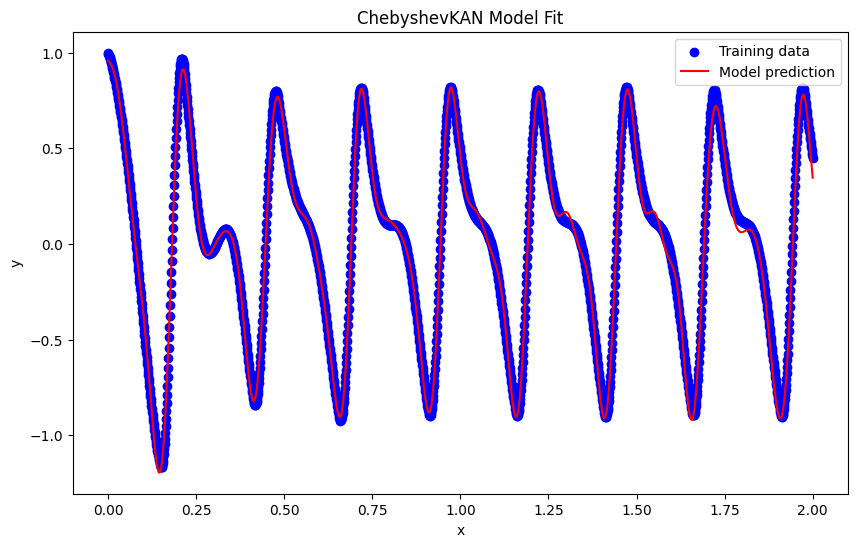

In [ ]:
# Evaluation
model.eval()
x_test = np.linspace(0, 2, 2000)
#x_test = x_train
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    y_test_pred = model(x_test_tensor).numpy()


# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color='blue', label='Training data')
plt.plot(x_test, y_test_pred, color='red', label='Model prediction')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('ChebyshevKAN Model Fit')
plt.show()

# PyKAN library

In [ ]:
!pip install -q pykan

In [ ]:
import kan

In [ ]:
def create_dataset(f,
                   n_var=2,
                   f_mode = 'col',
                   ranges = [-1,1],
                   train_num=1000,
                   test_num=1000,
                   normalize_input=False,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset

    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input variables. Default: [-1,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.

    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']

    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var,2)
    else:
        ranges = np.array(ranges)


    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:,i] = torch.rand(train_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        test_input[:,i] = torch.rand(test_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]

    if f_mode == 'col':
        train_label = f(train_input)
        test_label = f(test_input)
    elif f_mode == 'row':
        train_label = f(train_input.T)
        test_label = f(test_input.T)
    else:
        print(f'f_mode {f_mode} not recognized')

    # if has only 1 dimension
    if len(train_label.shape) == 1:
        train_label = train_label.unsqueeze(dim=1)
        test_label = test_label.unsqueeze(dim=1)

    def normalize(data, mean, std):
            return (data-mean)/std

    if normalize_input == True:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)

    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)

    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset

In [ ]:
from kan import *
from kan.MultKAN import MultKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,2,1,1], grid=3, k=3, seed=1, device=device)
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset(f, n_var=4, train_num=3000, device=device)

# train the model
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.002, lamb_entropy=2.);

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.05e-01 | test_loss: 3.09e-01 | reg: 1.10e+01 | : 100%|█| 20/20 [00:18<00:00,  1.10it

saving model version 0.1


In [ ]:
grids = np.array([3,5,10,20,50,100])
#grids = np.array([3,10])


train_losses = []
test_losses = []
steps = 200
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k, seed=0, device=device)
    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.22e-01 | test_loss: 4.12e-01 | reg: 5.20e+00 | : 100%|█| 200/200 [00:37<00:00,  5.34


saving model version 0.1
saving model version 0.2


| train_loss: 4.21e-01 | test_loss: 4.13e-01 | reg: 5.19e+00 | : 100%|█| 200/200 [00:25<00:00,  7.78


saving model version 0.3
saving model version 0.4


| train_loss: 4.20e-01 | test_loss: 4.14e-01 | reg: 5.21e+00 | : 100%|█| 200/200 [00:31<00:00,  6.31


saving model version 0.5
saving model version 0.6


| train_loss: 4.15e-01 | test_loss: 4.25e-01 | reg: 5.23e+00 | : 100%|█| 200/200 [01:00<00:00,  3.30


saving model version 0.7
saving model version 0.8


| train_loss: 4.04e-01 | test_loss: 4.41e-01 | reg: 5.31e+00 | : 100%|█| 200/200 [01:14<00:00,  2.69


saving model version 0.9
saving model version 0.10


| train_loss: 3.81e-01 | test_loss: 4.57e-01 | reg: 5.43e+00 | : 100%|█| 200/200 [02:24<00:00,  1.38

saving model version 0.11


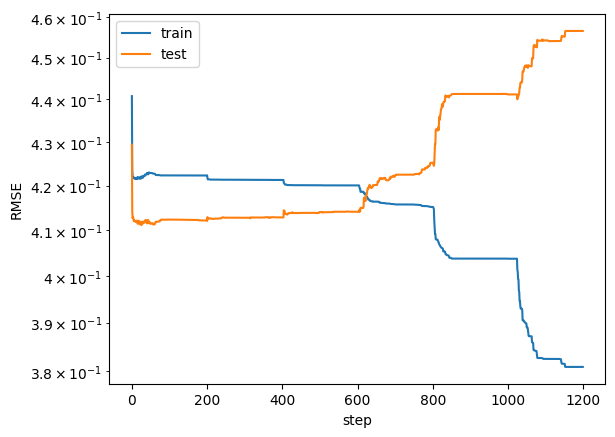

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

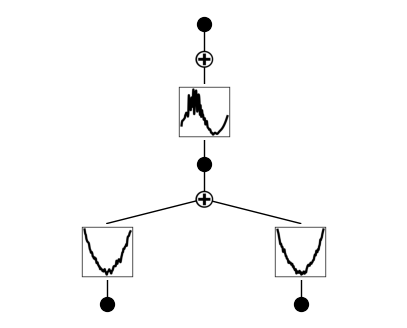

In [160]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

In [ ]:
model = model.prune(edge_th=1e-2)

saving model version 0.14


In [152]:
model.prune_edge()

saving model version 0.15


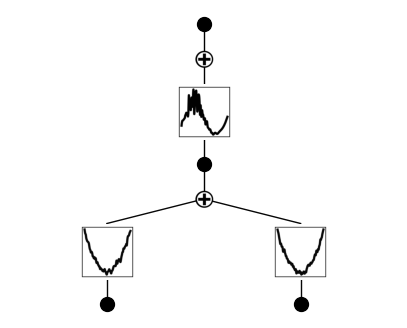

In [153]:
model.plot()

saving model version 0.16


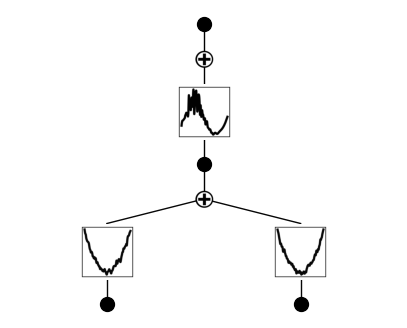

In [154]:
model = model.prune_node(active_neurons_id=[[0]])
model.plot()

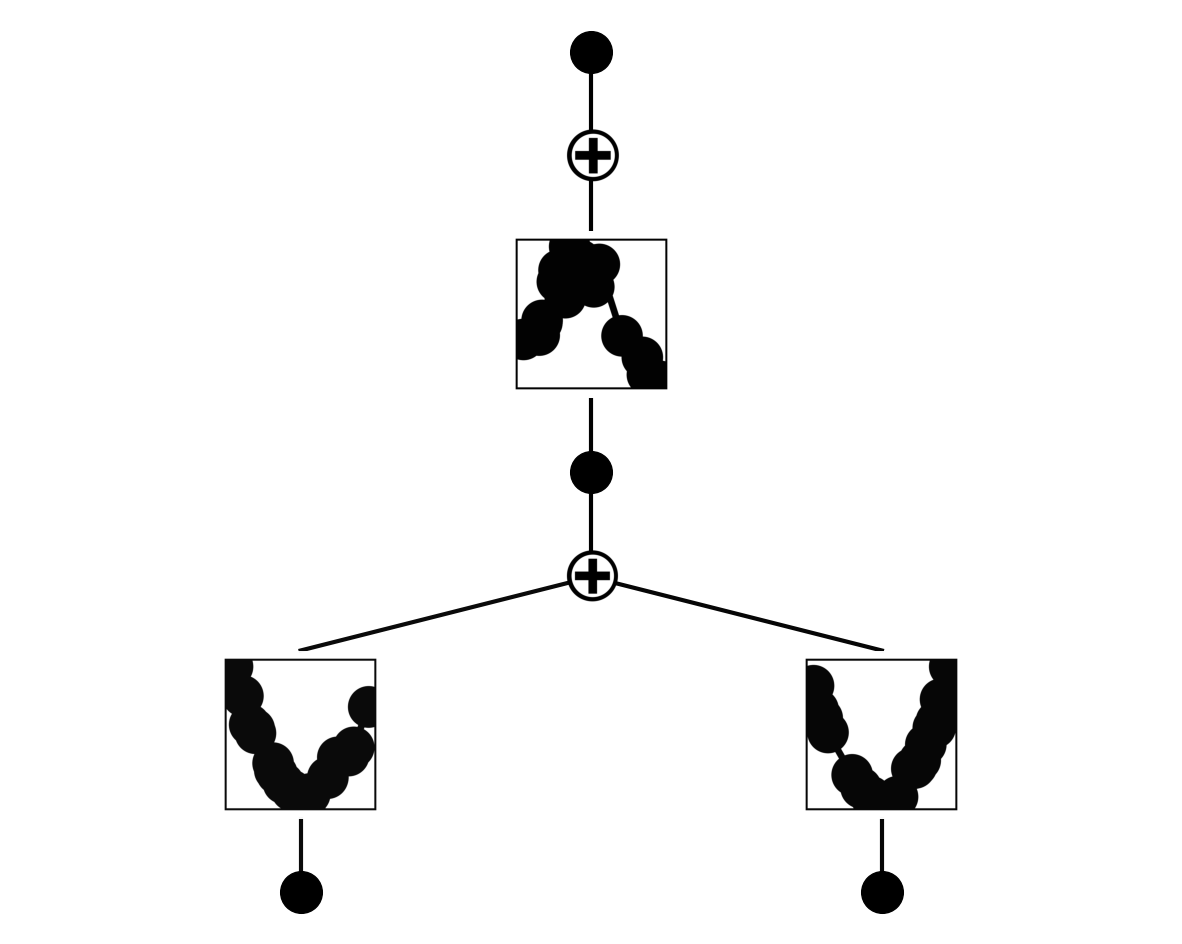

In [163]:
model.get_act(dataset['train_input'][:20])
model.plot(sample=True, scale=2)

In [164]:
 print(model.act_fun[0].grid)

Parameter containing:
tensor([[-1.0598, -1.0398, -1.0198, -0.9998, -0.9856, -0.9613, -0.9429, -0.9259,
         -0.9030, -0.8845, -0.8683, -0.8442, -0.8279, -0.8036, -0.7825, -0.7671,
         -0.7433, -0.7169, -0.6985, -0.6786, -0.6619, -0.6420, -0.6211, -0.5975,
         -0.5803, -0.5624, -0.5360, -0.5117, -0.4930, -0.4762, -0.4578, -0.4358,
         -0.4162, -0.4007, -0.3852, -0.3656, -0.3413, -0.3237, -0.3022, -0.2811,
         -0.2582, -0.2388, -0.2152, -0.1979, -0.1764, -0.1577, -0.1375, -0.1190,
         -0.1079, -0.0890, -0.0710, -0.0534, -0.0276, -0.0064,  0.0070,  0.0274,
          0.0453,  0.0616,  0.0826,  0.1007,  0.1282,  0.1456,  0.1686,  0.1874,
          0.2061,  0.2284,  0.2485,  0.2662,  0.2879,  0.3116,  0.3347,  0.3542,
          0.3730,  0.3895,  0.4058,  0.4258,  0.4422,  0.4654,  0.4839,  0.5020,
          0.5191,  0.5410,  0.5597,  0.5829,  0.6113,  0.6305,  0.6527,  0.6762,
          0.6906,  0.7142,  0.7421,  0.7616,  0.7881,  0.8022,  0.8220,  0.8368,
      

In [165]:
model.get_range(0,0,0)

x range: [-0.96 , 0.79 ]
y range: [-0.05 , -0.02 ]


(array(-0.9553485, dtype=float32),
 array(0.7928895, dtype=float32),
 array(-0.04512097, dtype=float32),
 array(-0.01845613, dtype=float32))

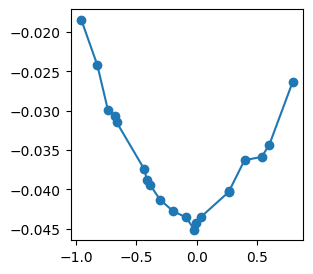

In [166]:
#edge is indexed as l,i,j
# where l is the layer index,
# i is the input neuron index,
# j and  is output neuron index.

l = 0
i = 0
j = 0
x, y = model.get_fun(l,i,j)

In [ ]:
model.get_range(l,i,j)

# KAN for classification

In [ ]:
!pip install -q pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
from kan import KAN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

In [ ]:
!pip install -U -q gensim
from gensim.models import Word2Vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.2 MB/s eta 0:00:00


In [ ]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
raw_table_data.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


In [ ]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()


# make new dataset from old columns
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()

,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,0.018810,659,128,170,258,518,81,77,79,0
1,0.018810,722,124,162,246,504,77,75,70,0
2,0.042009,600,130,162,244,474,79,72,77,1
3,0.027633,659,146,180,254,538,79,66,69,1
6,0.027633,952,146,198,282,598,24,80,20,1


In [ ]:
target_column_name = "Healthy_Status"

X = table_data[list(table_data.columns.drop([target_column_name]))]
y = table_data[target_column_name]

In [ ]:
# Split whole data to train and remainings
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=0)

# Split remainings data to val and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Covert data to torch tensor
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy()[:, None], dtype=torch.float32)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy()[:, None], dtype=torch.float32)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy()[:, None], dtype=torch.float32)

In [ ]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Create KAN
model = KAN(width=[9,3,1], grid=5, k=11, seed=0)
# create a KAN: 9D inputs, 1D output, and 3 hidden neurons. Power spline (k=11), 5 grid intervals (grid=5).

# Train KAN
results = model.fit({'train_input': train_input, 'train_label': train_label,
                       'test_input': val_input, 'test_label': val_label},
                      opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss()
                      )

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.04e-01 | test_loss: 4.06e-01 | reg: 2.79e+01 | : 100%|█| 50/50 [02:32<00:00,  3.05s/

saving model version 0.1


In [ ]:
# Predictions of train val and test datasets
test_preds = model.forward(test_input).detach()
test_labels = test_label

train_preds = model.forward(train_input).detach()
train_labels = train_label

val_preds = model.forward(val_input).detach()
val_labels = val_label


# Evaluate metrics
print("Train R2 Score:", r2_score(train_labels.numpy(), train_preds.numpy()))
print("Train MAE:", mean_absolute_error(train_labels.numpy(), train_preds.numpy()))

print("Val R2 Score:", r2_score(val_labels.numpy(), val_preds.numpy()))
print("Val MAE:", mean_absolute_error(val_labels.numpy(), val_preds.numpy()))

print("Test R2 Score:", r2_score(test_labels.numpy(), test_preds.numpy()))
print("Test MAE:", mean_absolute_error(test_labels.numpy(), test_preds.numpy()))

Train R2 Score: 0.19032317399978638
Train MAE: 0.34771209955215454
Val R2 Score: 0.19902974367141724
Val MAE: 0.3531486392021179
Test R2 Score: 0.12093645334243774
Test MAE: 0.36030566692352295


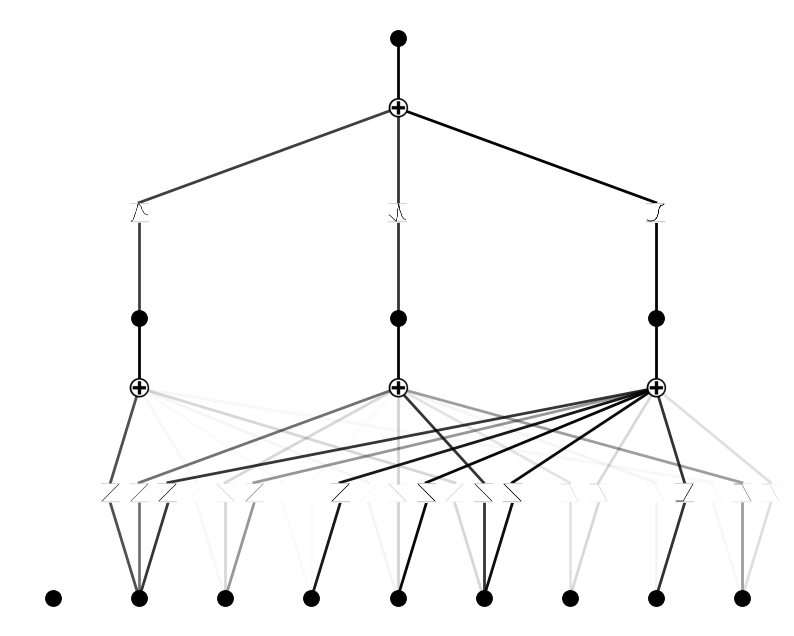

In [ ]:
#model.prune()
model.plot(scale=1)

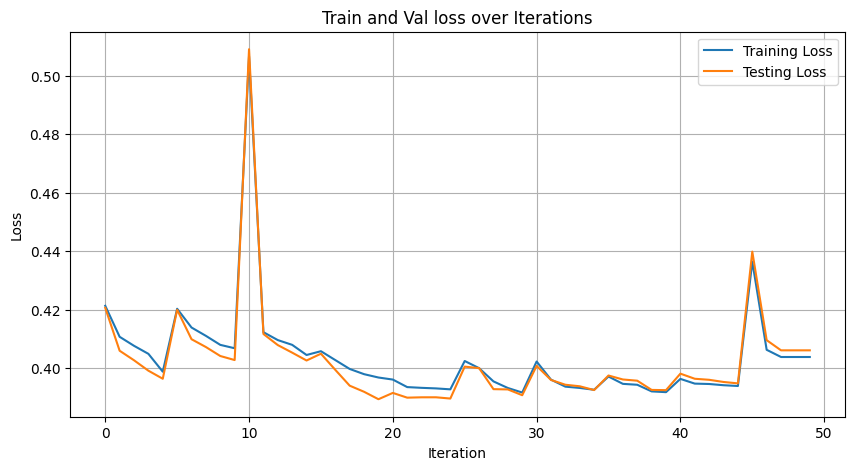

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(results["train_loss"], label='Training Loss')
plt.plot(results["test_loss"], label='Testing Loss')
plt.title('Train and Val loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
grids = np.array([3,5,10,20,50])


train_losses = []
test_losses = []
steps = 10
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[9,3,1], grid=grids[i], k=k, seed=0, device=device)
    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.15e-01 | test_loss: 4.16e-01 | reg: 1.32e+01 | : 100%|█| 10/10 [00:06<00:00,  1.55it


saving model version 0.1
saving model version 0.2


| train_loss: 4.08e-01 | test_loss: 4.11e-01 | reg: 1.28e+01 | : 100%|█| 10/10 [00:05<00:00,  1.99it


saving model version 0.3
saving model version 0.4


| train_loss: 4.08e-01 | test_loss: 4.11e-01 | reg: 1.28e+01 | : 100%|█| 10/10 [00:01<00:00,  5.61it


saving model version 0.5
saving model version 0.6


| train_loss: 4.08e-01 | test_loss: 4.11e-01 | reg: 1.28e+01 | : 100%|█| 10/10 [00:02<00:00,  4.90it


saving model version 0.7
saving model version 0.8


| train_loss: 4.06e-01 | test_loss: 4.08e-01 | reg: 1.29e+01 | : 100%|█| 10/10 [00:07<00:00,  1.28it

saving model version 0.9


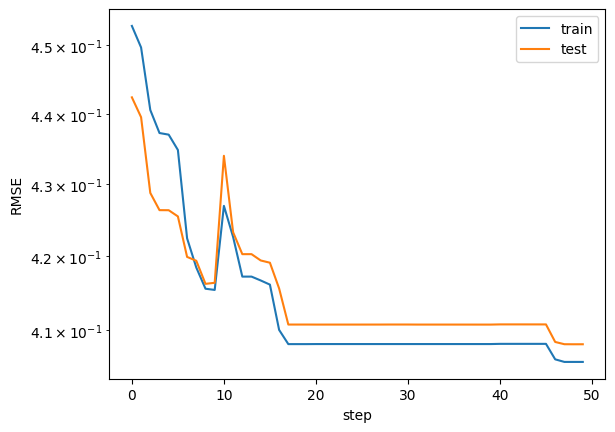

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

# RBF KAN example

https://github.com/sidhu2690/RBF-KAN/blob/main/RBF-KAN.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.init as init

In [ ]:
class RBFKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_centers, alpha=1.0):
        super(RBFKANLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_centers = num_centers
        self.alpha = alpha

        self.centers = nn.Parameter(torch.empty(num_centers, input_dim))
        init.xavier_uniform_(self.centers)

        self.weights = nn.Parameter(torch.empty(num_centers, output_dim))
        init.xavier_uniform_(self.weights)

    def multiquadratic_rbf(self, distances):
        return (1 + (self.alpha * distances) ** 2) ** 0.5

    def forward(self, x):
        distances = torch.cdist(x, self.centers)
        basis_values = self.multiquadratic_rbf(distances)
        output = torch.sum(basis_values.unsqueeze(2) * self.weights.unsqueeze(0), dim=1)
        return output

class RBFKAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_centers):
        super(RBFKAN, self).__init__()
        self.rbf_kan_layer = RBFKANLayer(input_dim, hidden_dim, num_centers)
        self.output_weights = nn.Parameter(torch.empty(hidden_dim, output_dim))
        init.xavier_uniform_(self.output_weights)

    def forward(self, x):
        x = self.rbf_kan_layer(x)
        x = torch.relu(x)
        x = torch.matmul(x, self.output_weights)
        return x


In [ ]:
# Define model
model = RBFKAN(9, 3, 1, num_centers=10)
optimizer = optim.AdamW(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()


for epoch in range(10):
    # Train
    model.train()
    total_loss = 0
    total_accuracy = 0

    optimizer.zero_grad()
    output = model(train_input)
    labels = train_label
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    accuracy = (output.argmax(dim=1) == labels).float().mean()
    total_loss += loss.item()
    total_accuracy += accuracy.item()

    #total_loss /= len(trainloader)
    #total_accuracy /= len(trainloader)

print(total_loss, total_accuracy)

0.0 0.7204176187515259


# Graph KAN

https://github.com/WillHua127/GraphKAN-Graph-Kolmogorov-Arnold-Networks